In [1]:
%matplotlib notebook

import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import scipy as sp
import nibabel as nib
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import lib.motion as motion
import lib.models as models

In [2]:
n = 64
batch_size = 100

# Set up model
model = models.get_full_model(n)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
model.load_weights('training/IMAGENET-CLEAN-STANDARD-False-500epoch-64/cp-0355.ckpt')

In [3]:
# Set up brain model
brain_model = models.get_full_model(n)
brain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
brain_model.load_weights('training/BRAIN-CLEAN-STANDARD-False-500epoch-64/cp-0500.ckpt')

In [4]:
# Set up corrupted brain model
corrupted_brain_model = models.get_full_model(n)
corrupted_brain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
corrupted_brain_model.load_weights('training/BRAIN-ALL-STANDARD-False-500epoch-64/cp-0500.ckpt')

In [5]:
# Set up brain convolutional model
conv_brain_model = models.get_conv_model(n)
conv_brain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
conv_brain_model.load_weights('training/BRAIN-ALL-CONV-False-500epoch-64/cp-0500.ckpt')

In [6]:
# Set up UNet model
unet_brain_model = models.get_Unet(n,'relu')
unet_brain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
unet_brain_model.load_weights('training/BRAIN-ALL-UNET-relu-FREQUENCY_DOMAIN-False-500epoch-64/cp-0230.ckpt')

In [7]:
def get_plotting_data(angle,num_pix,k_line,data_dir,ind):
    data_path = data_dir+os.listdir(data_dir)[ind]
    vol_data = np.load(data_path)['vol_data']
    _,_,z = vol_data.shape

    img_data = vol_data[:,:,int(z/2)]
    img_data = np.array(Image.fromarray(img_data).resize((n,n)))
    img_data = img_data-img_data.mean()
    img_data = img_data/np.max(img_data)

    corrupted_img,corrupted_k_raw = motion.add_rotation_and_translation(img_data,angle,num_pix,k_line,return_k=True)

    corrupted_k_all = np.expand_dims(corrupted_k_raw,-1)
    corrupted_k_re = np.real(corrupted_k_all)
    corrupted_k_im = np.imag(corrupted_k_all)
    corrupted_k = np.expand_dims(np.concatenate([corrupted_k_re,corrupted_k_im], axis=2), axis=0) 
    return img_data, corrupted_img, corrupted_k

<IPython.core.display.Javascript object>


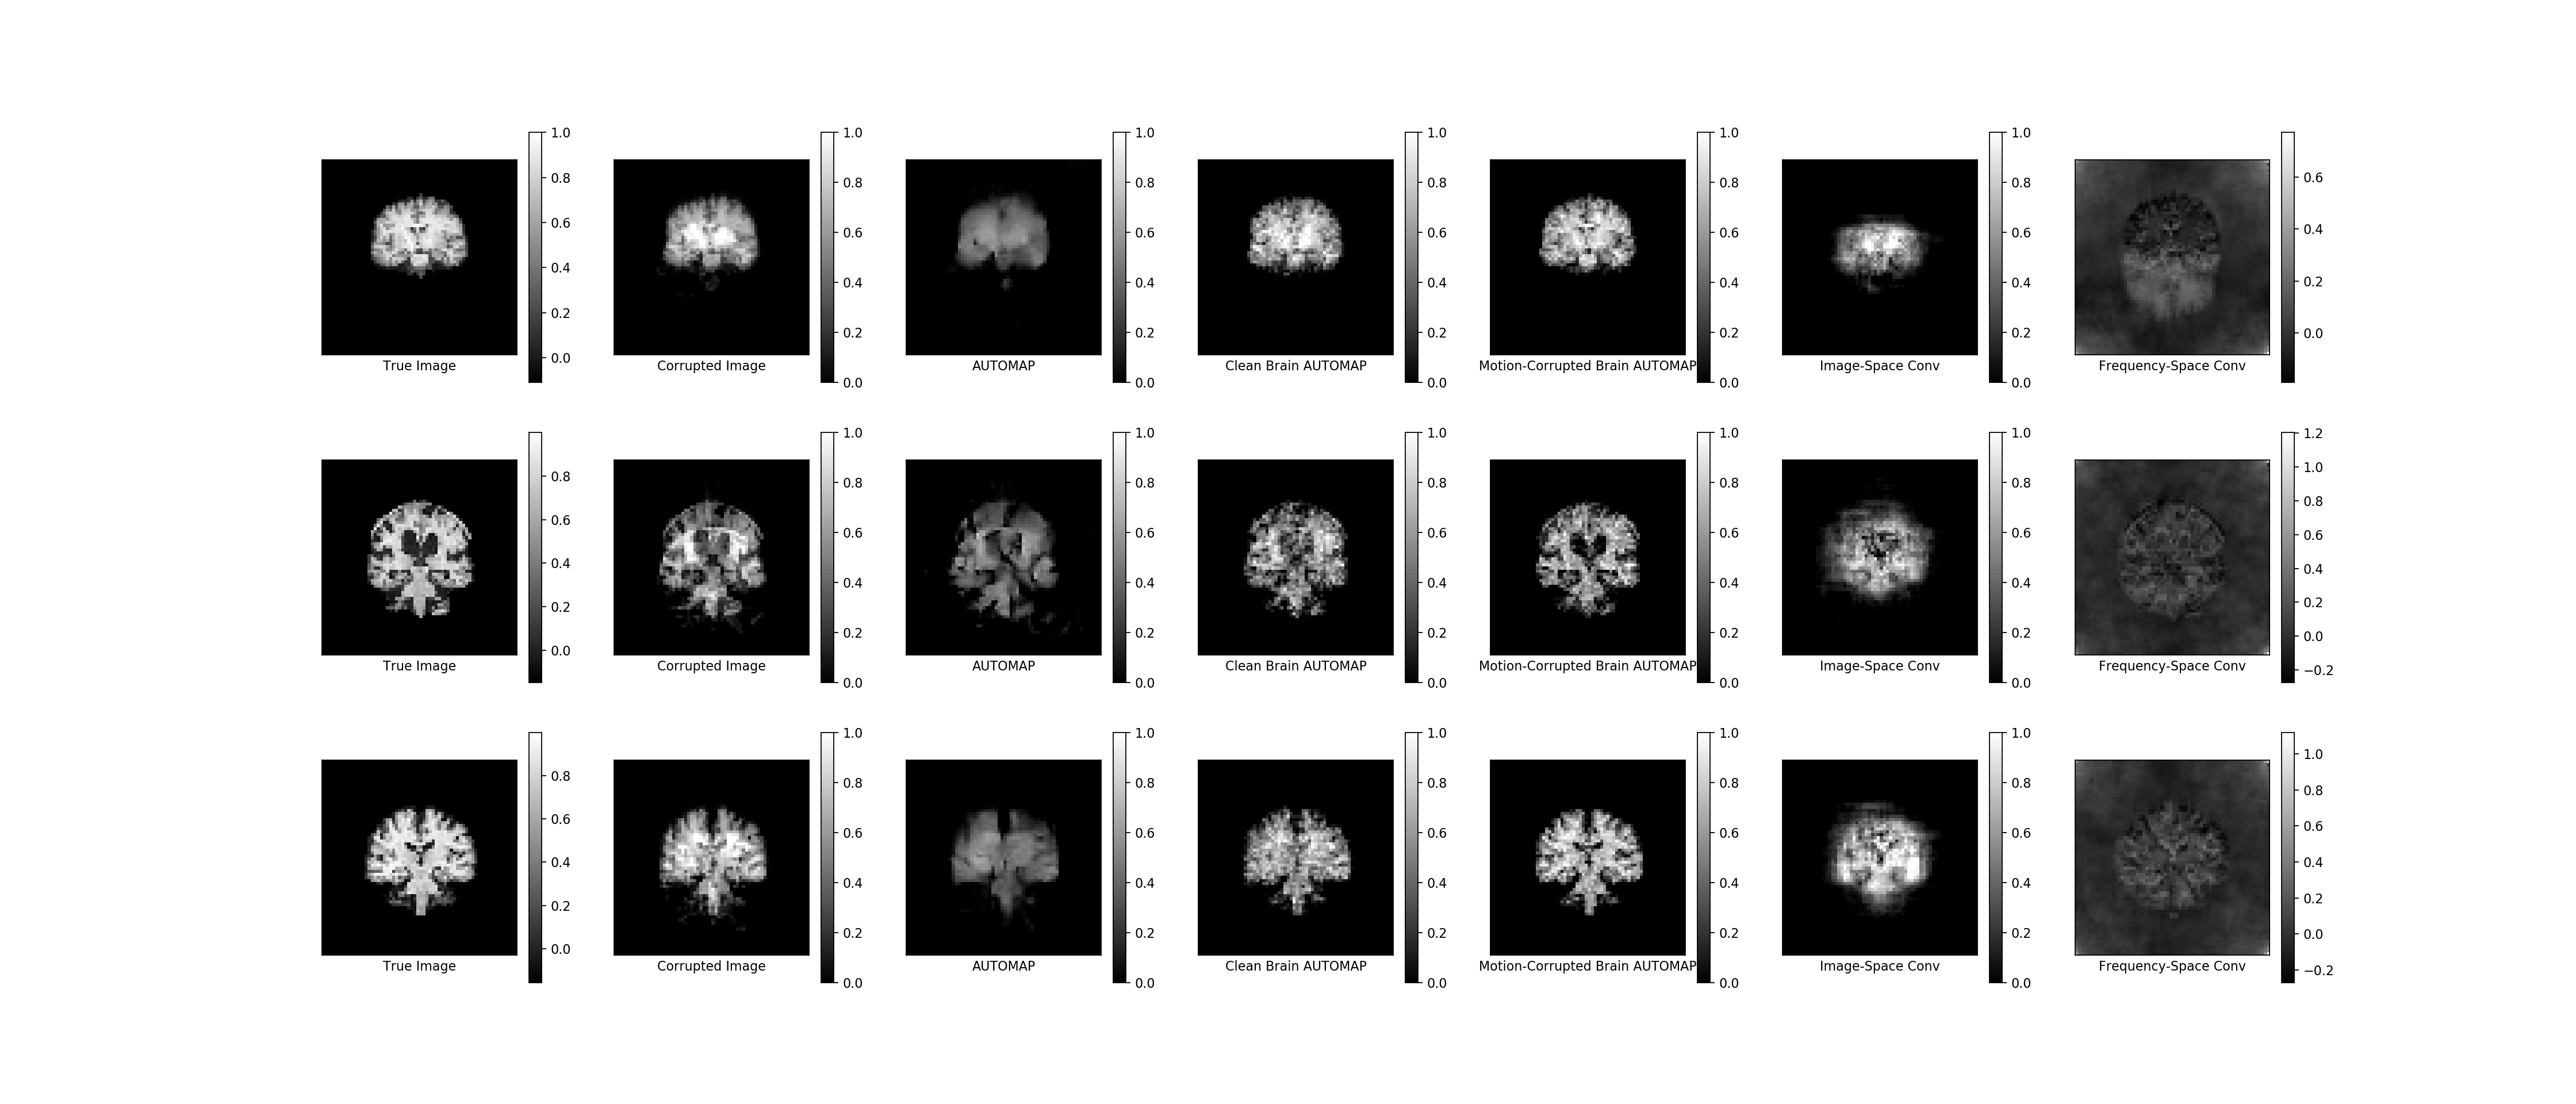

In [8]:
num_imgs = 3
num_pix = 8
angle = 30
k_line = 30

data_dir = '/data/ddmg/voxelmorph/data/t1_mix/proc/old/resize256-crop_0/test/vols/'

fig,axes = plt.subplots( num_imgs,7, figsize=[28,4*num_imgs] )

img_datas = []
corrupted_imgs = []
corrupted_ks = []

for i in range(num_imgs):
    img_data, corrupted_img, corrupted_k = get_plotting_data(angle,num_pix,k_line,data_dir,i)
    img_datas.append(img_data)
    corrupted_imgs.append(corrupted_img)
    corrupted_ks.append(corrupted_k)

for i,iax in enumerate(axes.flatten()):
    subj = int(i/7)
    img_data = img_datas[subj]
    corrupted_img = corrupted_imgs[subj]
    corrupted_k = corrupted_ks[subj]
    
    if i%7==0:
        true_img = np.rot90(img_data, axes=(1,0))
        im = iax.imshow(true_img,cmap='gray')
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('True Image')
        plt.colorbar(im,ax=iax)
    elif i%7==1:
        plot_corrupted_img = np.rot90((np.real(corrupted_img)), axes=(1,0))
        im = iax.imshow(plot_corrupted_img,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Corrupted Image')
        plt.colorbar(im,ax=iax)
    elif i%7==2:
        model_img = np.rot90(model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(model_img,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('AUTOMAP')
        plt.colorbar(im,ax=iax)
    elif i%7==3:
        model_img = np.rot90(brain_model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(model_img,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Clean Brain AUTOMAP')
        plt.colorbar(im,ax=iax)
    elif i%7==4:
        corrupted_3_15_predict = np.rot90(corrupted_brain_model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(np.real(corrupted_3_15_predict),cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Motion-Corrupted Brain AUTOMAP')
        plt.colorbar(im,ax=iax)
    elif i%7==5:
        corrupted_predict = np.rot90(conv_brain_model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(corrupted_predict,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Image-Space Conv')
        plt.colorbar(im,ax=iax)
    elif i%7==6:
        unet_reconstruction = np.imag(np.fft.ifft2(np.fft.ifftshift(unet_brain_model.predict(corrupted_k)[0,:,:,0]+1j*unet_brain_model.predict(corrupted_k)[0,:,:,1])))
        unet_predict = np.rot90(unet_reconstruction, axes=(1,0))
        im = iax.imshow(np.real(unet_predict),cmap='gray')
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Frequency-Space Conv')
        plt.colorbar(im,ax=iax)

In [9]:
def plot_trend(param_array, img_datas, corrupted_imgs, corrupted_ks, suffix):
    num_imgs = len(img_datas)
    fig,axes = plt.subplots( num_imgs,7, figsize=[28,4*num_imgs] )
    
    for i,iax in enumerate(axes.flatten()):
        subj = int(i/7)
        img_data = img_datas[subj]
        ind = subj*3+int(((i-1)%7)/2)
        if i%7!=0:
            corrupted_img = corrupted_imgs[ind]
            corrupted_k = corrupted_ks[ind]

        num_pix_array = [10,20,30]
            
        if i%7==0:
            true_img = np.rot90(img_data, axes=(1,0))
            im = iax.imshow(true_img,cmap='gray')
            iax.set_yticks([])
            iax.set_xticks([])
            iax.set_xlabel('True Image')
            plt.colorbar(im,ax=iax)
        elif (i%7-1)%2==0:
            plot_corrupted_img = np.rot90(corrupted_brain_model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
            im = iax.imshow(plot_corrupted_img,cmap='gray',vmin=0,vmax=1)
            iax.set_yticks([])
            iax.set_xticks([])
            iax.set_xlabel(str(param_array[int((i%7-1)/2)])+suffix)
            plt.colorbar(im,ax=iax)
        elif (i%7-1)%2==1:
            model_img = np.rot90(np.abs(corrupted_brain_model.predict(corrupted_k)[0,:,:,0]-img_data), axes=(1,0))
            im = iax.imshow(model_img,cmap='gray',vmin=0,vmax=1)
            iax.set_yticks([])
            iax.set_xticks([])
            iax.set_xlabel(str(param_array[int((i%7-1)/2)])+suffix+' error')
            plt.colorbar(im,ax=iax)

<IPython.core.display.Javascript object>


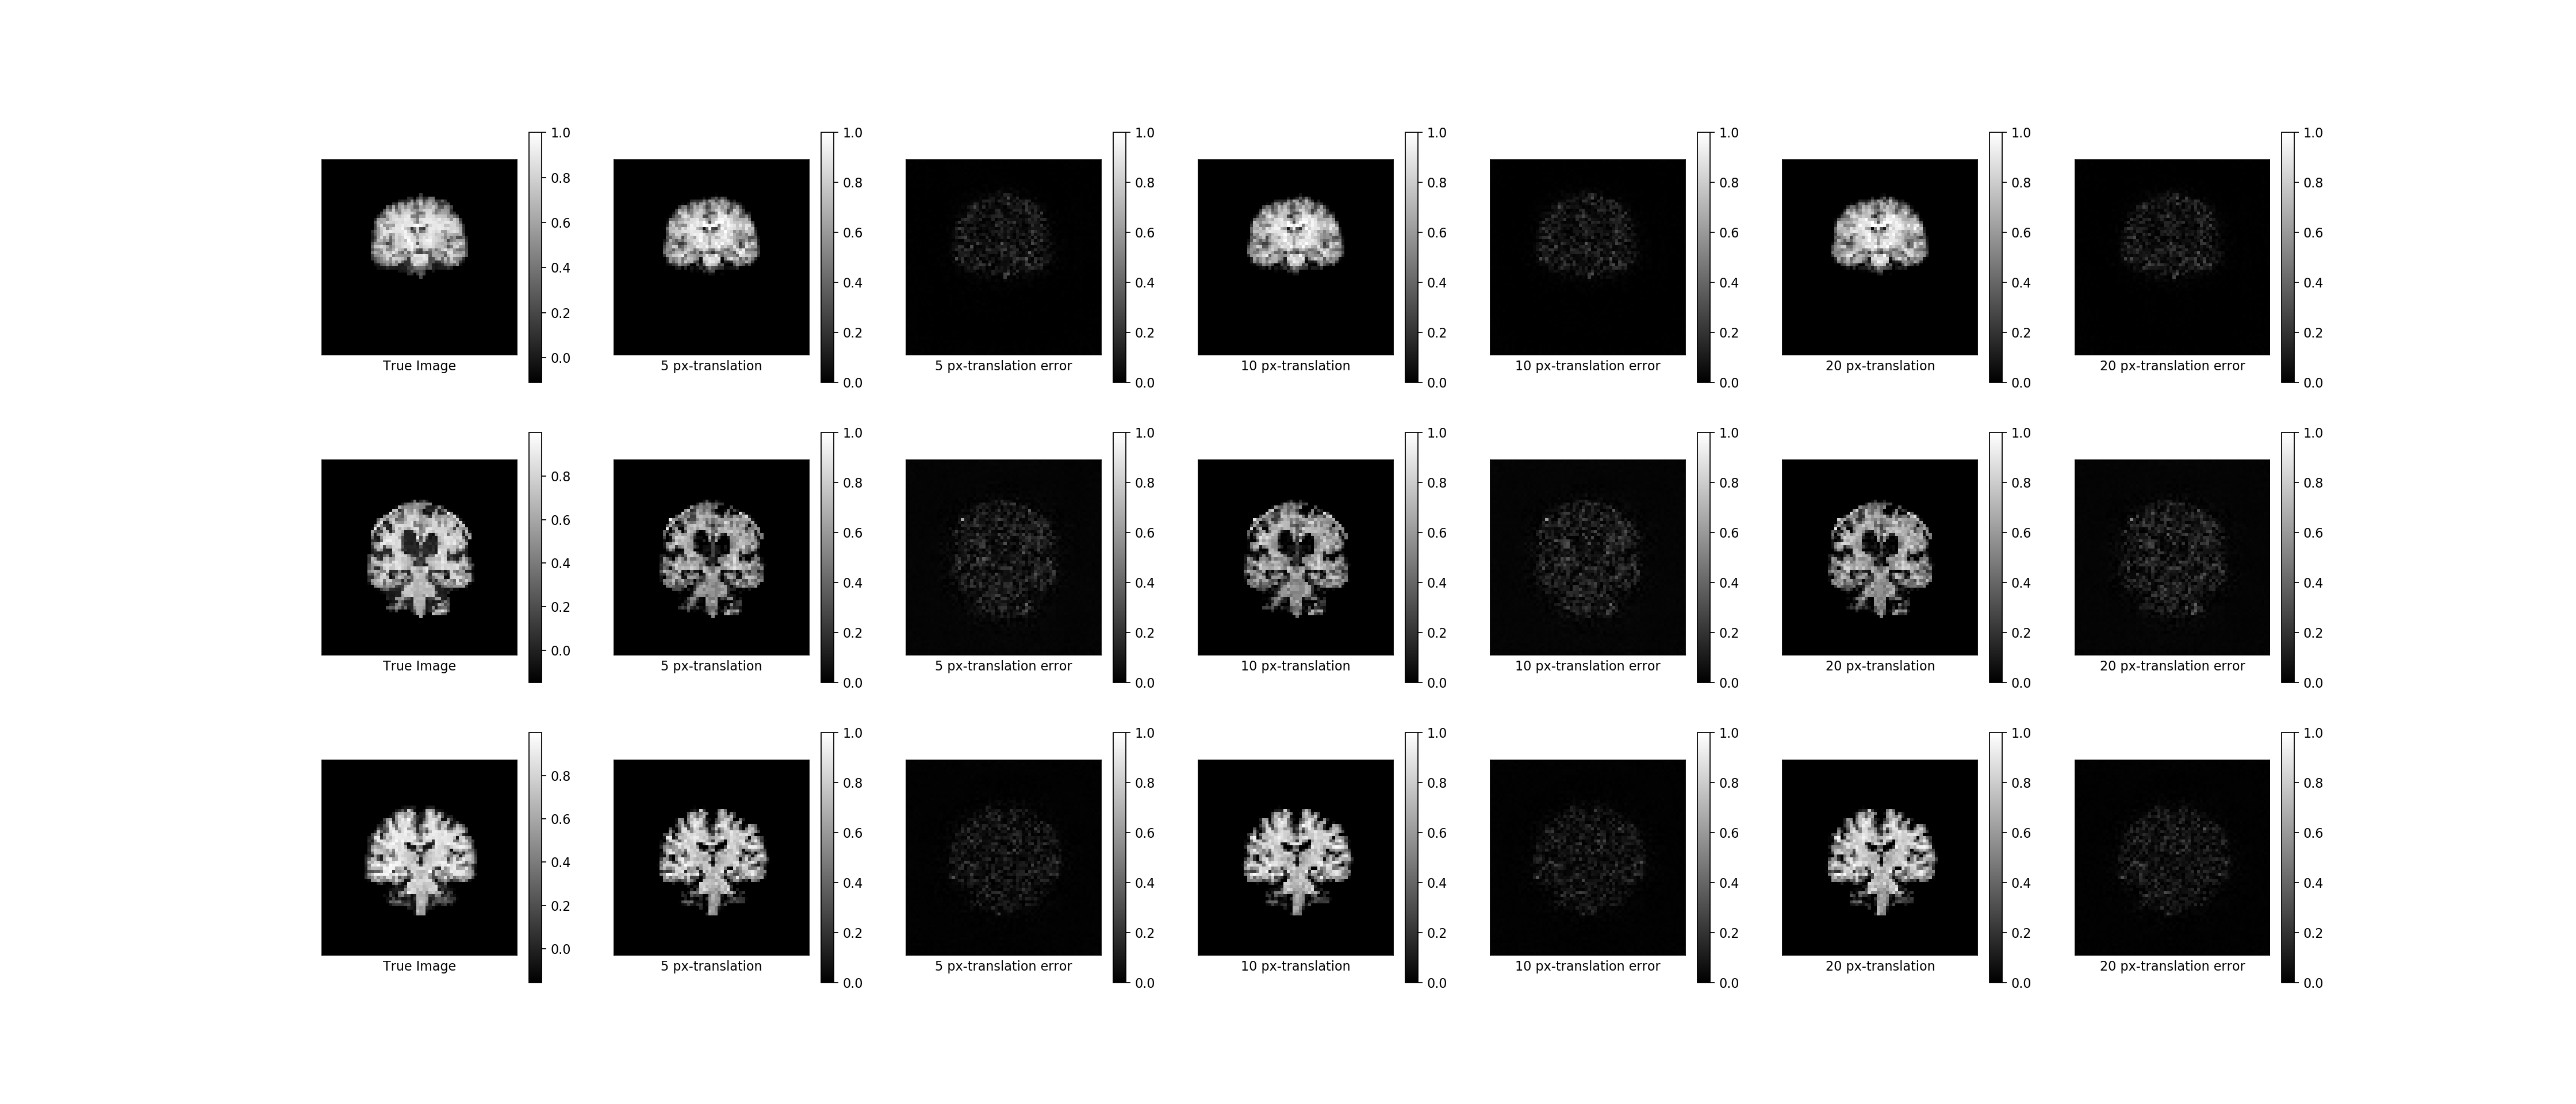

In [10]:
num_imgs = 3
num_pix_array = [5,10,20]
angle = 10
k_line = 10
suffix = ' px-translation'

img_datas = []
corrupted_imgs = []
corrupted_ks = []

for i in range(num_imgs):
    for num_pix in num_pix_array:
        img_data, corrupted_img, corrupted_k = get_plotting_data(angle,num_pix,k_line,data_dir,i)
        if(num_pix==num_pix_array[0]):
            img_datas.append(img_data)
        corrupted_imgs.append(corrupted_img)
        corrupted_ks.append(corrupted_k)
        
plot_trend(num_pix_array, img_datas, corrupted_imgs, corrupted_ks, suffix)

<IPython.core.display.Javascript object>


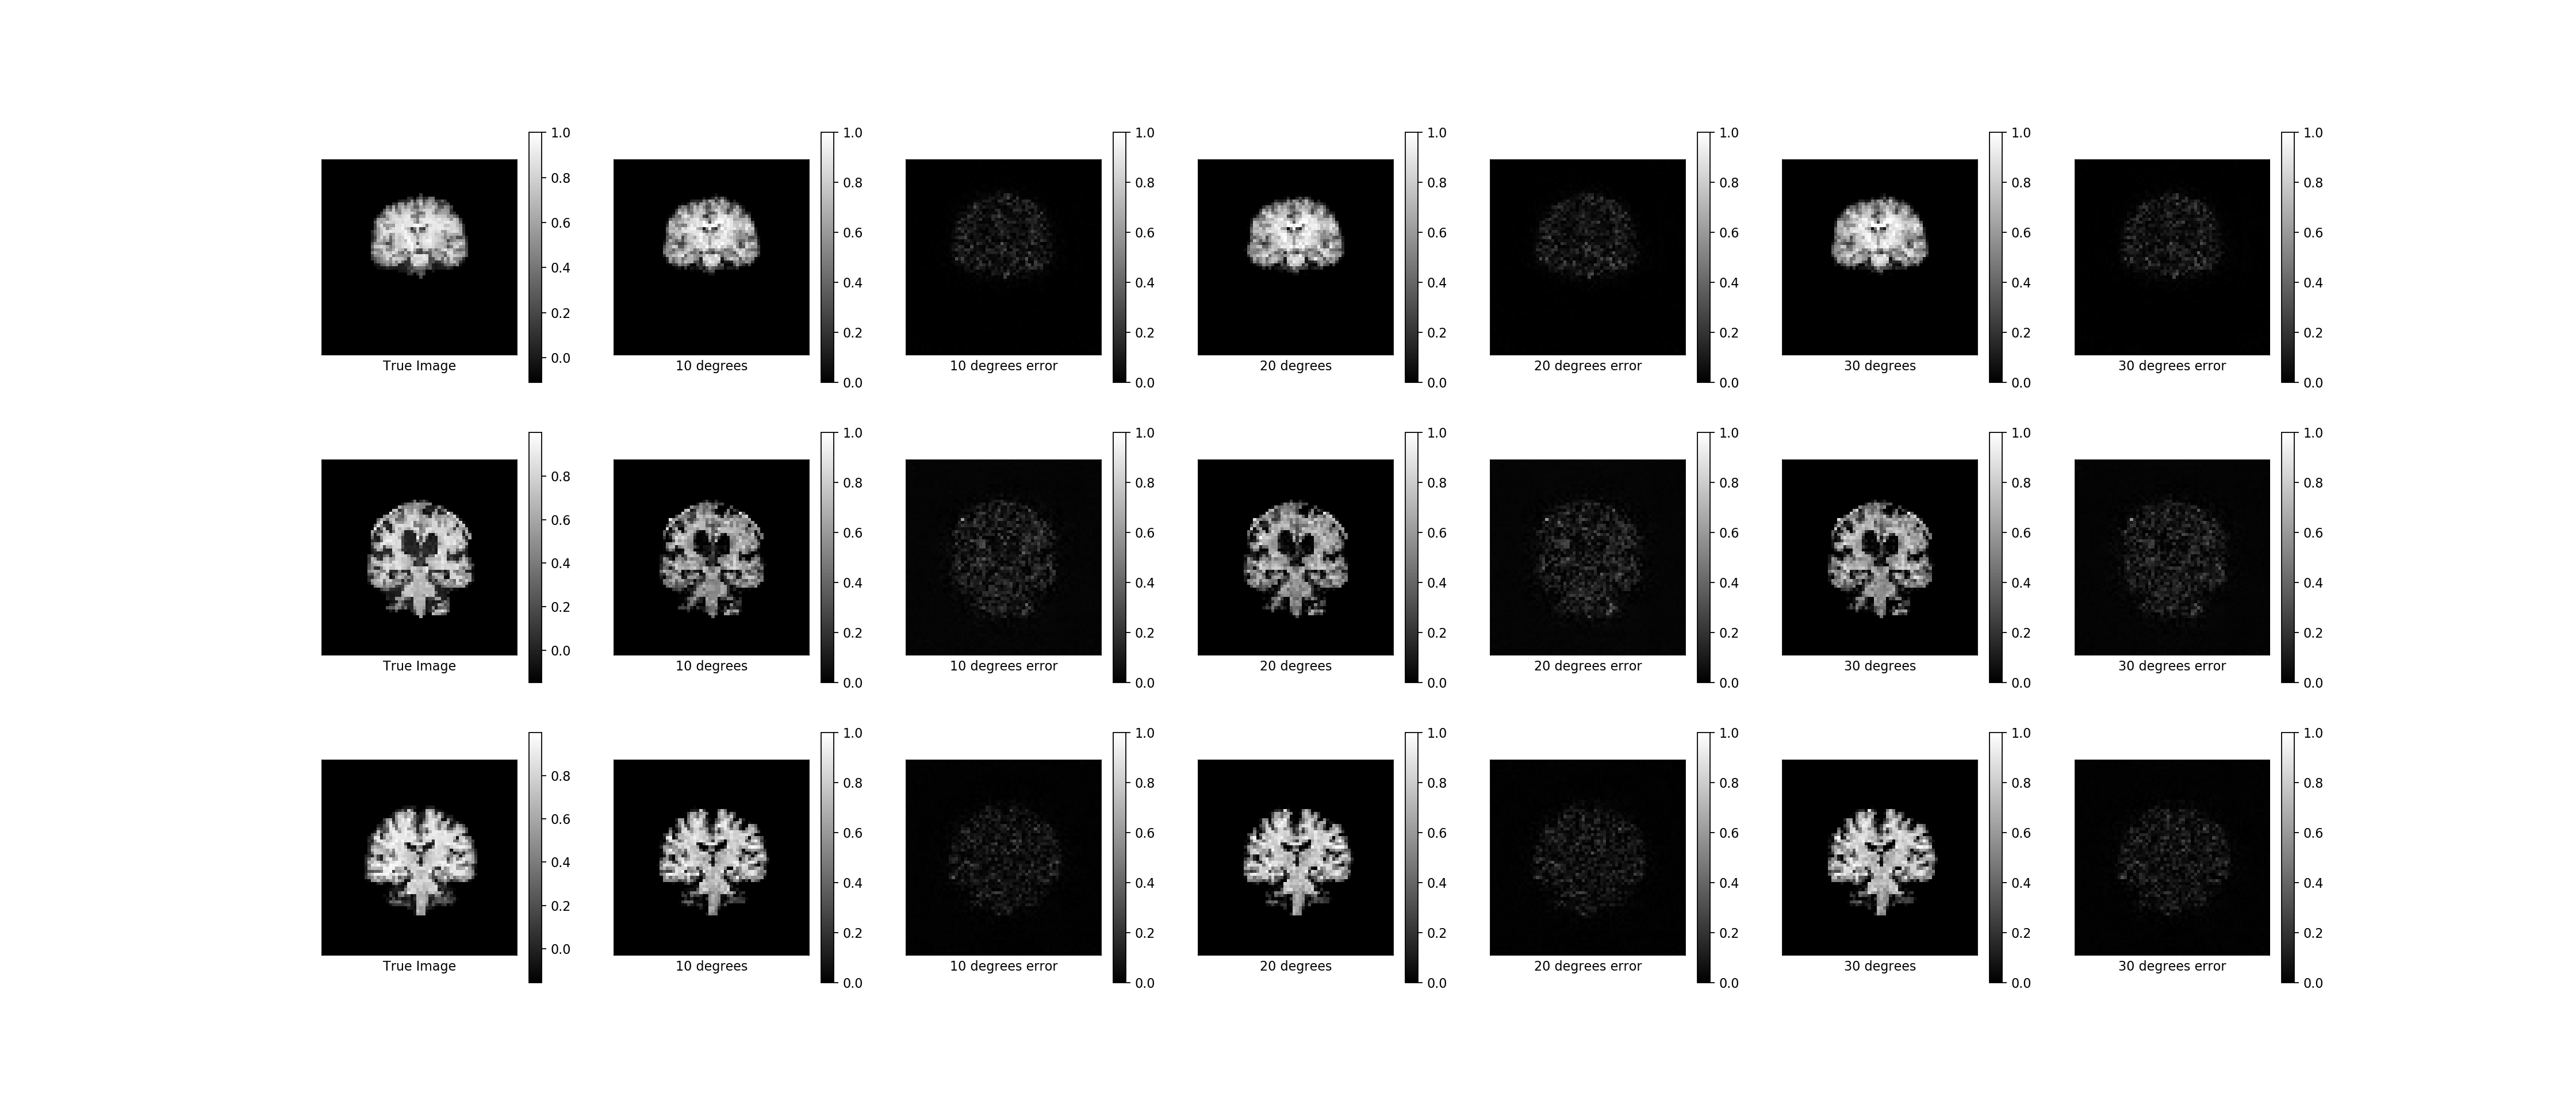

In [11]:
num_imgs = 3
num_pix = 10
angle_array = [10,20,30]
k_line = 10
suffix = ' degrees'

img_datas = []
corrupted_imgs = []
corrupted_ks = []

for i in range(num_imgs):
    for angle in angle_array:
        img_data, corrupted_img, corrupted_k = get_plotting_data(angle,num_pix,k_line,data_dir,i)
        if(angle==angle_array[0]):
            img_datas.append(img_data)
        corrupted_imgs.append(corrupted_img)
        corrupted_ks.append(corrupted_k)
        
plot_trend(angle_array, img_datas, corrupted_imgs, corrupted_ks, suffix)

<IPython.core.display.Javascript object>


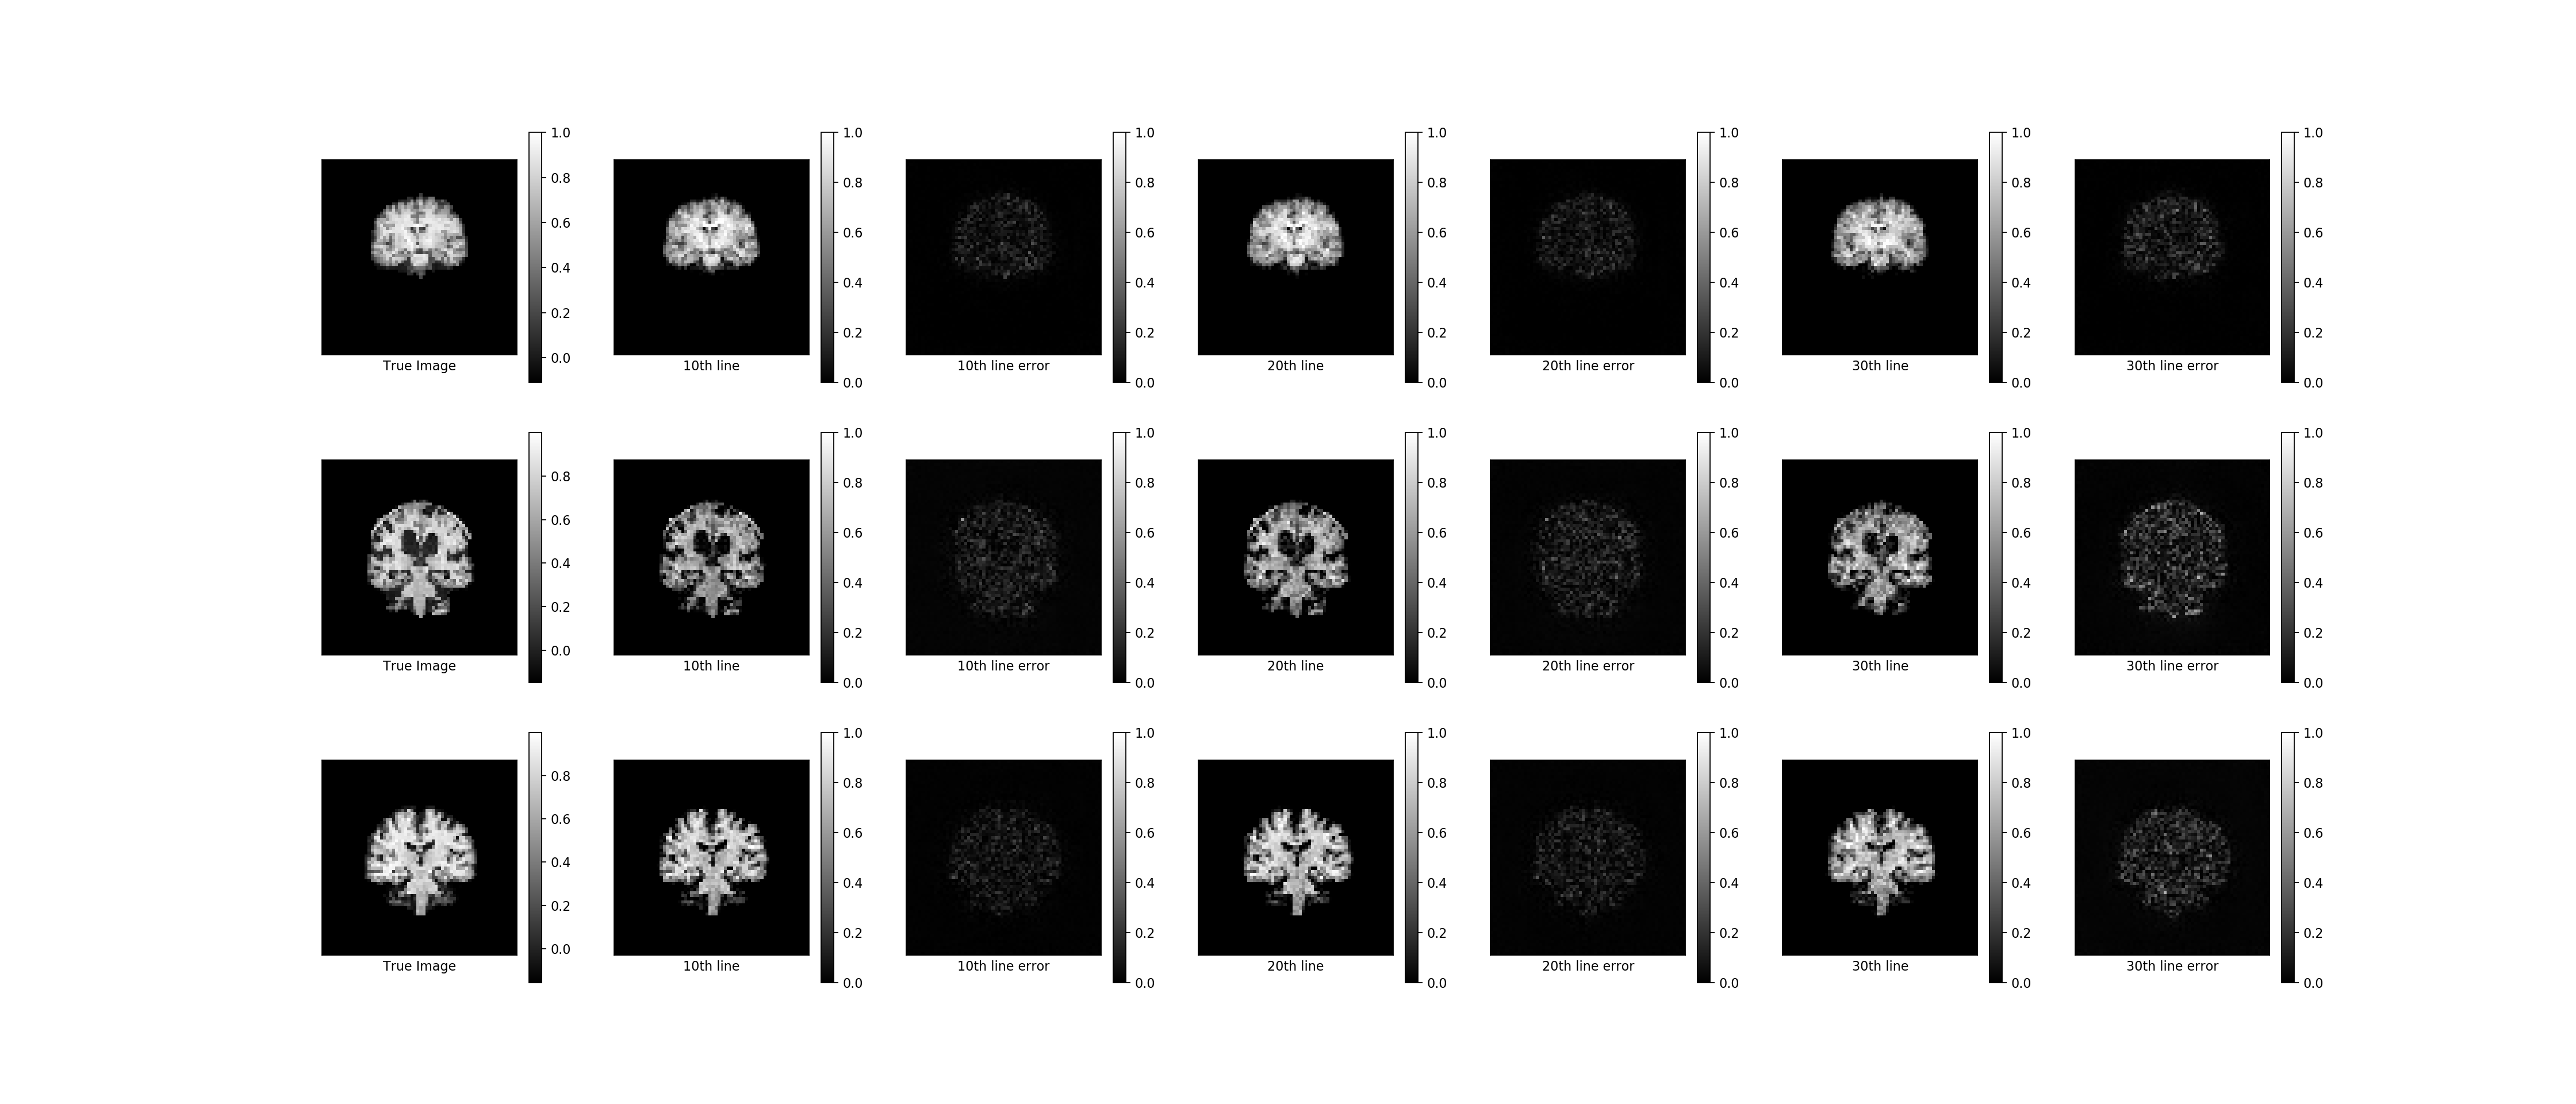

In [12]:
num_imgs = 3
num_pix = 10
angle_array = 20
k_line_array = [10,20,30]
suffix = 'th line'

img_datas = []
corrupted_imgs = []
corrupted_ks = []

for i in range(num_imgs):
    for k_line in k_line_array:
        img_data, corrupted_img, corrupted_k = get_plotting_data(angle,num_pix,k_line,data_dir,i)
        if(k_line==k_line_array[0]):
            img_datas.append(img_data)
        corrupted_imgs.append(corrupted_img)
        corrupted_ks.append(corrupted_k)
        
plot_trend(k_line_array, img_datas, corrupted_imgs, corrupted_ks, suffix)
plt.savefig('brains.png')